In [1]:
import os
import sys
import glob
import pickle
import yaml
from tqdm import tqdm
import itertools


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
sys.path.append("..")

In [3]:
import metrics
import utils

In [4]:
SAVE = False

In [9]:
#results_dir = "../results/small/active"
results_dir = "../results/proto_v5b"

In [11]:
config_files = glob.glob(f"{results_dir}/*/*/*/*.yaml")
config_files

['../results/proto_v5b/active/speechbrain_2022-02-15/23-20-20/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_label_spread.yaml',
 '../results/proto_v5b/active/speechbrain_2022-02-15/22-58-35/config_speechbrain_trimmed_2sec_cos_emb_avg.yaml',
 '../results/proto_v5b/active/speechbrain_2022-02-15/23-31-25/config_speechbrain_trimmed_2sec_score_plda_sph.yaml',
 '../results/proto_v5b/active/speechbrain_2022-02-15/22-59-09/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_kmeans.yaml',
 '../results/proto_v5b/active/speechbrain_2022-02-15/23-13-29/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_vb_plda_sph.yaml',
 '../results/proto_v5b/active/speechbrain_2022-02-15/23-19-36/config_speechbrain_trimmed_2sec_score_cos_sc_avg.yaml',
 '../results/proto_v5b/active/speechbrain_2022-02-15/23-09-16/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_ahc_plda_sph.yaml',
 '../results/proto_v5b/active/xvector_2022-02-16/20-50-52/config_xvector_trimmed_2sec_score_plda_diag.yaml',
 '../results/pr

In [12]:
config_files = ['../results/proto_v5b/active/speechbrain_2022-02-16/19-47-37/config_speechbrain_trimmed_2sec_cos_emb_avg.yaml', 
                '../results/proto_v5b/active/speechbrain_2022-02-16/19-47-54/config_speechbrain_trimmed_2sec_score_cos_sc_avg.yaml', 
                '../results/proto_v5b/active/speechbrain_2022-02-16/19-49-06/config_speechbrain_trimmed_2sec_score_plda_sph.yaml']

In [13]:
frr_point = 1


results_dict = {}

for config_file in tqdm(config_files):
    
    print(os.path.basename(config_file).split('.')[0])
    
    config_dir = os.path.dirname(config_file)
    config = yaml.load(open(config_file), Loader=yaml.FullLoader)
    
    embeddings_name = config["embeddings_name"] # ['clova', 'speechbrain', 'xvector']
    embeddings_type = config["embeddings_type"]

    score_type = config["score_type"] # ['cos_emb_avg', 'cos_sc_avg', 'plda_sph', 'plda_diag']
    by_the_book = config["by_the_book"] # plda scoring
    preprocessing_name = config["preprocessing_name"]
    recognizer = config["recognizer"] # ['exp_avg', 'memory'], use 'memory' for 'cos_sc_avg'
    #sequential_updates = config["sequential_updates"]
    
    params = config["params"]
    if isinstance(params, dict):
        algorithm = params.get("algorithm", ["centroid"])[0]
    else:
        algorithm = "centroid"

    #
        
    run_name = f"{embeddings_name}_{embeddings_type}_{score_type}_{algorithm}"
#     if not sequential_updates:
#         run_name = f"{run_name}_offline"
    if embeddings_name == "xvector" and by_the_book:
        run_name = f"{run_name}_by-the-book"
    print(run_name)
    
    
    FAR_known_list_noadapt = []
    FAR_unknown_list_noadapt = []
    EER_known_list_noadapt = []
    EER_unknown_list_noadapt = []
    
    
    FAR_known_list = []
    FAR_unknown_list = []
    EER_known_list = []
    EER_unknown_list = []
    
#     thresholds = []


    params_dict = {"alpha": [], "Fa": [], "Fb": [], "algorithm": [], "threshold": []}
    
    for results_dir_iter in [dir_name for dir_name in glob.glob(f"{config_dir}/*") if os.path.isdir(dir_name)]:
        #print(results_dir_iter)
        
        try:
            with open(f"{results_dir_iter}/params.pickle", "rb") as params_file:
                params = pickle.load(params_file)
            #print(params)
        except:
            print(f"Failed to load params for {results_dir_iter}")
            continue
            
            
#         thresholds += [params["threshold"]]
        
        for key in params_dict.keys():
            val = params.get(key, np.nan)
            val = val if val is not None else np.nan
            params_dict[key].append(val)
                

        try:
            scores_target_pooled = np.loadtxt(f"{results_dir_iter}/scores_tar.txt")
            scores_impostor_known_pooled = np.loadtxt(f"{results_dir_iter}/scores_imp.txt")
            scores_impostor_unknown_pooled = np.loadtxt(f"{results_dir_iter}/scores_imp_unk.txt")

            scores_target_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_tar.txt")
            scores_impostor_known_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_imp.txt")
            scores_impostor_unknown_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_imp_unk.txt")
        except:
            print(f"Failed to load scores for {results_dir_iter}")
            continue
            
        # no adaptation
        scores, labels = utils.concatenate_with_labels(scores_impostor_known_pooled, scores_target_pooled)
        FAR_at_FRR_known, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_known = metrics.eer(scores, labels)[0]*100

        scores, labels = utils.concatenate_with_labels(scores_impostor_unknown_pooled, scores_target_pooled)
        FAR_at_FRR_unknown, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_unknown = metrics.eer(scores, labels)[0]*100
        
        FAR_known_list_noadapt += [FAR_at_FRR_known]
        FAR_unknown_list_noadapt += [FAR_at_FRR_unknown]
        EER_known_list_noadapt += [EER_known]
        EER_unknown_list_noadapt += [EER_unknown] 
        
    
        # adapted
        scores, labels = utils.concatenate_with_labels(scores_impostor_known_pooled_enrich, scores_target_pooled_enrich)
        FAR_at_FRR_known, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_known = metrics.eer(scores, labels)[0]*100

        scores, labels = utils.concatenate_with_labels(scores_impostor_unknown_pooled_enrich, scores_target_pooled_enrich)
        FAR_at_FRR_unknown, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_unknown = metrics.eer(scores, labels)[0]*100

        FAR_known_list += [FAR_at_FRR_known]
        FAR_unknown_list += [FAR_at_FRR_unknown]
        EER_known_list += [EER_known]
        EER_unknown_list += [EER_unknown]   
        
        
#     thresholds = np.array(thresholds)
#     alphas = np.array(alphas)

    FAR_known_list_noadapt = np.array(FAR_known_list_noadapt)
    FAR_unknown_list_noadapt = np.array(FAR_unknown_list_noadapt)
    EER_known_list_noadapt = np.array(EER_known_list_noadapt)
    EER_unknown_list_noadapt = np.array(EER_unknown_list_noadapt)
    
    FAR_known_list = np.array(FAR_known_list)
    FAR_unknown_list = np.array(FAR_unknown_list)
    EER_known_list = np.array(EER_known_list)
    EER_unknown_list = np.array(EER_unknown_list)
    
    
    results_dict_run = {}
    results_dict_run['FAR_known_noadapt'] = FAR_known_list_noadapt
    results_dict_run['FAR_unknown_noadapt'] = FAR_unknown_list_noadapt
    results_dict_run['EER_know_noadapt'] = EER_known_list_noadapt
    results_dict_run['EER_unknown_noadapt'] = EER_unknown_list_noadapt
    
    results_dict_run['FAR_known'] = FAR_known_list
    results_dict_run['FAR_unknown'] = FAR_unknown_list
    results_dict_run['EER_know'] = EER_known_list
    results_dict_run['EER_unknown'] = EER_unknown_list
    results_dict_run['params'] = params_dict
    
    for key, val in params_dict.items():
        params_dict[key] = np.array(val)
    
    
    # sort
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    idx_sort = np.argsort(thresholds)
    
    for key, val in results_dict_run.items():
        if isinstance(val, np.ndarray):
            results_dict_run[key] = val[idx_sort]
        elif isinstance(val, dict):
            for k, v in val.items():
                if isinstance(v, np.ndarray):
                    val[k] = v[idx_sort]
                else:
                    print("Error")
                    
    results_dict[run_name] = results_dict_run


  0%|          | 0/3 [00:00<?, ?it/s]

config_speechbrain_trimmed_2sec_cos_emb_avg
speechbrain_trimmed_2sec_cos_emb_avg_centroid


 33%|███▎      | 1/3 [00:45<01:30, 45.26s/it]

config_speechbrain_trimmed_2sec_score_cos_sc_avg
speechbrain_trimmed_2sec_cos_sc_avg_centroid


 67%|██████▋   | 2/3 [01:30<00:45, 45.49s/it]

config_speechbrain_trimmed_2sec_score_plda_sph
speechbrain_trimmed_2sec_plda_sph_centroid


100%|██████████| 3/3 [02:14<00:00, 44.85s/it]


In [14]:
results_dict.keys()

dict_keys(['speechbrain_trimmed_2sec_cos_emb_avg_centroid', 'speechbrain_trimmed_2sec_cos_sc_avg_centroid', 'speechbrain_trimmed_2sec_plda_sph_centroid'])

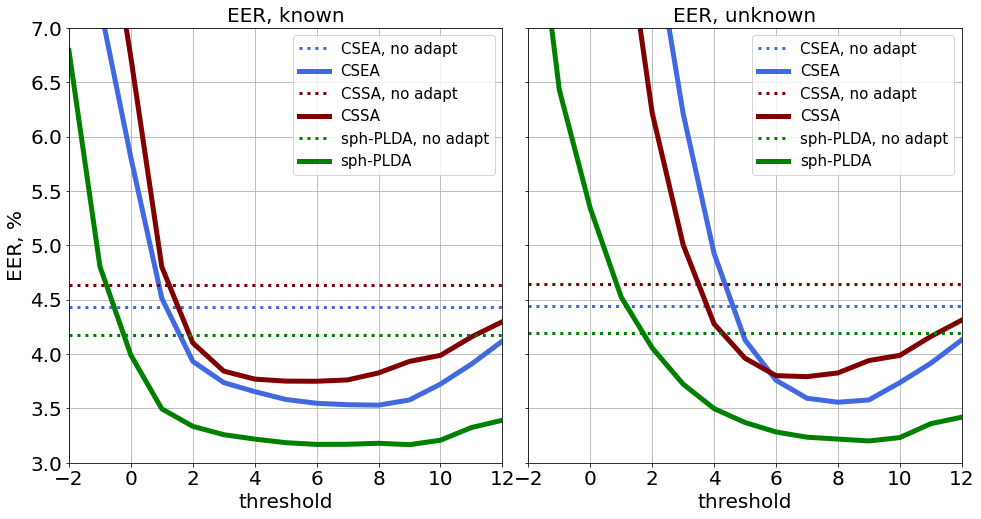

In [37]:
fig = plt.figure(figsize=(16, 8))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
#ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set(ylim=(3, 7))
ax[1].set(ylim=(3, 7))
ax[0].set_title("EER, known", fontsize=20)
ax[1].set_title("EER, unknown", fontsize=20)
tick_font = 15
ax[0].xaxis.get_label().set_fontsize(tick_font)
ax[0].yaxis.get_label().set_fontsize(tick_font)
ax[1].xaxis.get_label().set_fontsize(tick_font)
ax[1].yaxis.get_label().set_fontsize(tick_font)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)


colors = ['royalblue', 'maroon', 'green']

labels = ["CSEA", "CSSA", "sph-PLDA"]

for i, run_name in enumerate(['speechbrain_trimmed_2sec_cos_emb_avg_centroid', 
                              'speechbrain_trimmed_2sec_cos_sc_avg_centroid', 
                              'speechbrain_trimmed_2sec_plda_sph_centroid']):

    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    alphas = params_dict['alpha']
    
    
    # w/o adaptation
    FAR_known_noadapt = results_dict_run['FAR_known_noadapt']
    FAR_unknown_noadapt = results_dict_run['FAR_unknown_noadapt']
    EER_known_noadapt = results_dict_run['EER_know_noadapt']
    EER_unknown_noadapt = results_dict_run['EER_unknown_noadapt']

    label = f"{labels[i]}, no adapt"
    ax[0].plot(thresholds[:], EER_known_noadapt[:], color=f"{colors[i]}", linestyle=":", label=label, linewidth=3);
    ax[0].legend()
    ax[1].plot(thresholds[:], EER_unknown_noadapt[:], color=f"{colors[i]}", linestyle=":", label=label, linewidth=3);
    ax[1].legend()    
    
    ax[0].grid() 
    ax[1].grid() 


    # w/ adaptation                
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']


    mask_nan = np.isnan(alphas)
    mask_num = np.logical_not(mask_nan)

    label = labels[i]
    ax[0].plot(thresholds[mask_nan], EER_known[mask_nan], f"{colors[i]}", label=label, linewidth=5);
    ax[0].legend(prop={'size': 15}) 

    ax[1].plot(thresholds[mask_nan], EER_unknown[mask_nan], f"{colors[i]}", label=label, linewidth=5);
    ax[1].legend(prop={'size': 15}) 
    
    

# start, end = ax[0].get_ylim()
# ax[0].yaxis.set_ticks(np.arange(start, end, 1));

ax[0].xaxis.label.set_size(20)
ax[0].yaxis.label.set_size(20)
ax[1].xaxis.label.set_size(20)
#ax[1].yaxis.label.set_size(20)

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.06, hspace=0)

plt.savefig("fig/speechbrain_centroid_scoring_comparison.pdf", bbox_inches="tight", dpi=300)

In [18]:
results_dict.keys()

dict_keys(['speechbrain_trimmed_2sec_cos_emb_avg_centroid', 'speechbrain_trimmed_2sec_cos_sc_avg_centroid', 'speechbrain_trimmed_2sec_plda_sph_centroid'])